## Create Flood Inundation Map based on the HAND Method

**Authors**: Anthony Castronova (acastronova@cuahsi.org), Irene Garousi-Nejad (igarousi@cuahsi.org)  <br>
**Last updated**: Mar 26, 2024

This notebook demonstrates how to generate flood inundation maps using the methodology and datasets defined by https://github.com/noAA-OWP/inundation-mapping. All data used in this notebook are publicly acessible via Amazon AWS. 

This work was funded by:

 <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CUAHSI-4-color-logo_with_URL.png" width="300" height="300" style="padding-right:50px"> <img src="https://www.hydroshare.org/resource/dc269e23ff494a06b7372bc6034a5de2/data/contents/v3-SNOW/logo-img/CIROHLogo_200x200.png" width="100" height="20">    

In [1]:
import numpy
import xarray
import rioxarray
import geopandas
import fim_utils as fim
from pathlib import Path
import matplotlib.pyplot as plt
from geocube.api.core import make_geocube

## Collect Data

Collect the required input datasets for the FIM computation, we've staged some for public access in the CUAHSI cloud. For access to all available FIM input datasets, please refer to the documentation at https://github.com/noAA-OWP/inundation-mapping. 

In [2]:
# hydroTable_0.csv
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/07010108/branches/0/hydroTable_0.csv .

# rem_zeroed_masked_0.tif
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
 s3 cp s3://scratch/hand_fim/07010108/branches/0/rem_zeroed_masked_0.tif .

# gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg
!aws --no-sign-request --endpoint-url https://api.minio.cuahsi.io \
s3 cp s3://scratch/hand_fim/07010108/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg .

download: s3://scratch/hand_fim/07010108/branches/0/hydroTable_0.csv to ./hydroTable_0.csv
download: s3://scratch/hand_fim/07010108/branches/0/rem_zeroed_masked_0.tif to ./rem_zeroed_masked_0.tif
download: s3://scratch/hand_fim/07010108/branches/0/gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg to ./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg


Define a feature of interest and a hypothetical streamflow

In [43]:
# feature id of interest
nhd_feature_id=4966269

# hypothetical streamflow (cms).
# This can be replaced with a flow value gathered by a source of your choice
cms = 85

Use the streamflow defined above to interpolate river stage from a rating curve for all hydroids that exist within this NHD+ reach. 

In [44]:
stage_dict = fim.get_stage_for_all_hydroids_in_reach(nhd_feature_id, cms)

In [45]:
stage_dict

{16850150: 1.628307814885818,
 16850151: 1.8670552948517722,
 16850152: 1.6024277741685045,
 16850153: 1.8802166173794508,
 16850154: 1.2674877389273402}

Load the precomputed HAND raster that was obtained from AWS.

In [46]:
xds = rioxarray.open_rasterio(Path('./rem_zeroed_masked_0.tif'),
                              masked=True).squeeze().drop_vars('band').to_dataset(name='hand')

Make a copy of the 'hand' variable to the 'stage' variable. This will be used to compute the flood inundation map later on. The dataset will now have both `hand` and `stage` variables for all (x,y) locations.

In [47]:
xds['stage'] = xds.hand.copy(deep=True)
xds

<xarray.Dataset>
Dimensions:      (x: 9817, y: 7974)
Coordinates:
  * x            (x) float64 2.757e+04 2.758e+04 ... 1.257e+05 1.257e+05
  * y            (y) float64 2.606e+06 2.606e+06 ... 2.526e+06 2.526e+06
    spatial_ref  int64 0
Data variables:
    hand         (y, x) float32 ...
    stage        (y, x) float32 ...

Read watershed geometries and set stage values from the `stage_dict` defined above, and remove all other geometries. The end product will be a geodataframe containing the geometries for each `hydroid` in our area of interest and their stage values.

In [48]:
geodf = geopandas.read_file(Path('./gw_catchments_reaches_filtered_addedAttributes_crosswalked_0.gpkg'))

# loop over each reach and set the corresponding stage
# in the geopandas object
for hydroid, stage in stage_dict.items():
    geodf.loc[geodf.HydroID==hydroid, 'stage'] = stage

# remove all nan values to make our dataset smaller
geodf_filtered = geodf[geodf.stage.notnull()]

geodf_filtered

,HydroID,S0,LengthKm,LakeID,From_Node,To_Node,NextDownID,areasqkm,feature_id,order_,src_calibrated,geometry,stage
606,16850150,0.001,1.458112,-999.0,476,477,16850151,1.2233,4966269,4,False,"POLYGON ((84359.409 2557454.282, 84459.409 255...",1.628308
620,16850151,0.001,1.459533,-999.0,477,478,16850152,1.1002,4966269,4,False,"POLYGON ((85359.409 2556964.282, 85369.409 255...",1.867055
645,16850152,0.001,1.457817,-999.0,478,479,16850153,1.1430,4966269,4,False,"POLYGON ((85889.409 2555794.282, 85929.409 255...",1.602428
656,16850153,0.001,1.462965,-999.0,479,480,16850154,1.2663,4966269,4,False,"POLYGON ((86459.409 2555904.282, 86479.409 255...",1.880217
658,16850154,0.001,1.414386,-999.0,480,471,16850145,1.1323,4966269,4,False,"POLYGON ((86959.409 2555184.282, 87039.409 255...",1.267488


Add these geometries to the Dataset containing `hand` and `stage` variables using a GeoCube.

In [49]:
# create a grid for the geocube
out_grid = make_geocube(
    vector_data=geodf,
    measurements=['HydroID'],
    like=xds # ensure the data are on the same grid
)

# add stage and hydroID to the HAND raster
#xds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )
ds = xds.assign_coords( hydroid = (['y', 'x'], out_grid.HydroID.data) )

# drop everything except the HydroIDs that we're interested in
ds = ds.where(ds.hydroid.isin(geodf_filtered.HydroID), drop=True)
ds

<xarray.Dataset>
Dimensions:      (y: 358, x: 387)
Coordinates:
  * x            (x) float64 8.401e+04 8.402e+04 ... 8.786e+04 8.787e+04
  * y            (y) float64 2.557e+06 2.557e+06 ... 2.554e+06 2.554e+06
    spatial_ref  int64 0
    hydroid      (y, x) float64 1.685e+07 1.685e+07 ... 1.685e+07 1.685e+07
Data variables:
    hand         (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan
    stage        (y, x) float32 nan nan nan nan nan nan ... nan nan nan nan nan

Update the stage values in the DataSet where specific hydroid's exist.

In [50]:
for idx, row in geodf_filtered.iterrows():
    print(f'{row.HydroID} -> {row.stage}' )
    ds['stage'] = xarray.where(ds.hydroid == row.HydroID, row.stage, ds.stage)

16850150 -> 1.628307814885818
16850151 -> 1.8670552948517722
16850152 -> 1.6024277741685045
16850153 -> 1.8802166173794508
16850154 -> 1.2674877389273402


Preview the `stage` data we set as well as the original `hand` data. 

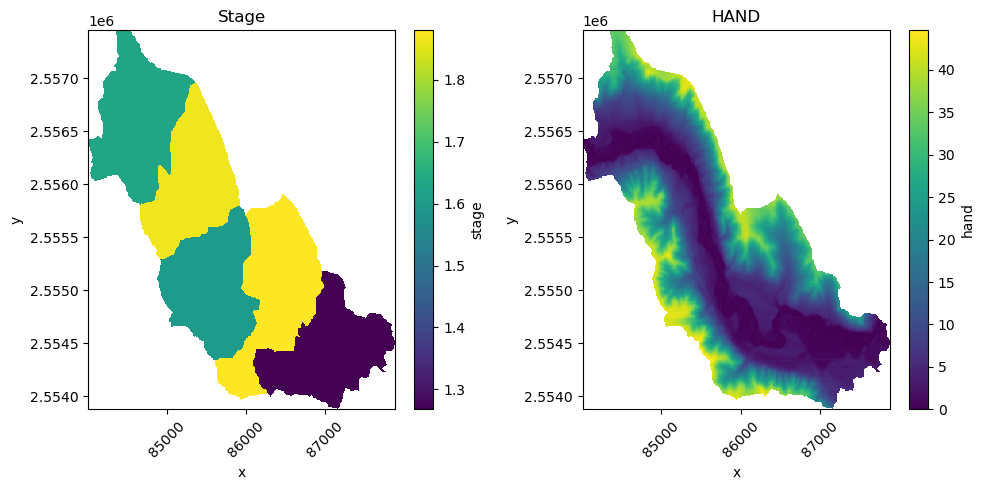

In [69]:
figure, axes = plt.subplots(1, 2, figsize=(10,5))

# plot stage
ds.stage.plot(ax=axes[0])
axes[0].set_title('Stage');
axes[0].tick_params(axis='x', labelrotation=45)

# plot hand
ds.hand.plot(ax=axes[1])
axes[1].set_title('HAND');
axes[1].tick_params(axis='x', labelrotation=45)

figure.tight_layout()


Compute FIM by subtracting `hand` from `stage`. Everything that is negative should be set to zero. Cells that have a value greater than zero indicate areas in which flooding occurs. Create a new variable in our dataset (called `fim`) to store this result.

In [52]:
ds['fim'] = ds.stage - ds.hand
ds['fim'] = xarray.where(ds.fim >= 0.00001, ds.fim, numpy.nan)

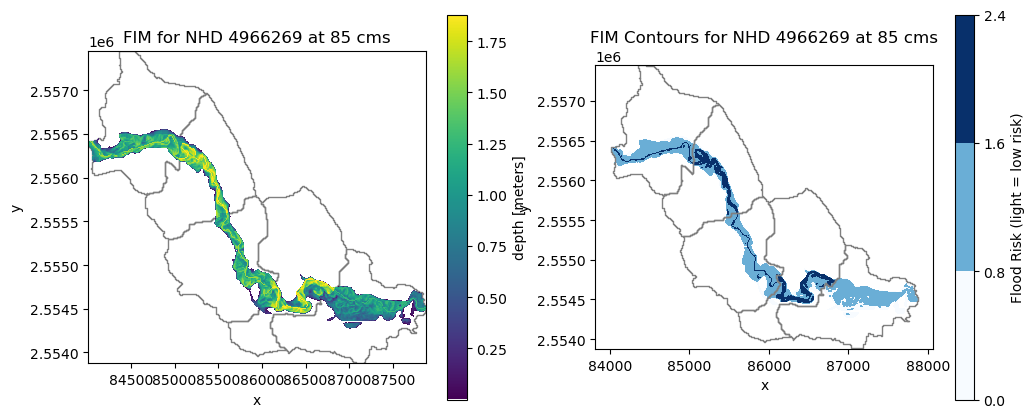

In [73]:
figure, axes = plt.subplots(1, 2, figsize=(12,5))

geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[0], edgecolor='grey', facecolor='None');
ds.fim.plot(cbar_kwargs={'label':'depth [meters]'}, ax=axes[0]);
axes[0].set_title(f'FIM for NHD {nhd_feature_id} at {cms} cms');





xarray.plot.contourf(ds.fim, levels=4, cmap='Blues', cbar_kwargs={'label':'Flood Risk (light = low risk)'}, ax=axes[1]);
geodf.loc[geodf.feature_id==nhd_feature_id].plot(ax=axes[1], edgecolor='grey', facecolor='None');
axes[1].set_title(f'FIM Contours for NHD {nhd_feature_id} at {cms} cms');
